In [1]:
import yt
from yt import YTArray
from astropy import constants as const
import sys
import h5py as h5
import trident
import numpy as np
import os.path
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns
import palettable
sns.set_style("white",{'font.family':'serif', 'axes.grid': True})
#for trident: git checkout 8b71bb81879a4d86b6d6c5e83c10971ece4e5d96
# for yt : git checkout ea857e75c2670fbb8f03de18017ff1a1b4a43e21
#sys.path.append('../analysis')
#import spectrum_generating_tools as spg

/Users/irynabutsky/software/yt/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /Users/irynabutsky/.config/yt/ytrc is deprecated in favor of /Users/irynabutsky/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0 . This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [107]:
ds = yt.load('/Users/irynabutsky/simulations/patient0/pioneer.003195')
#trident.add_ion_fields(ds, ions = ['O VI', 'H I'])

# load in data of start and end coordinates of all the rays
ray_id, impact, bvx, bvy, bvz, xi, yi, zi, xf, yf, zf = np.loadtxt('../../data/unanalyzed_spectra/P0_z0.25_ray_data.dat', skiprows = 1, unpack = True,\
                                                    usecols = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))

# for annoying reasons... need to convert ray positions to "code units"
code_unit_conversion = ds.domain_right_edge.d / ds.domain_right_edge.in_units('kpc').d
start_pos = np.ndarray(shape=(0, 3))
end_pos = np.ndarray(shape=(0, 3))
for i in range(len(xi)):
    start_pos = np.vstack((start_pos, [xi[i], yi[i], zi[i]] * code_unit_conversion))
    end_pos = np.vstack((end_pos, [xf[i], yf[i], zf[i]] * code_unit_conversion))

ray_center = start_pos[10] + 0.5*(end_pos[10] - start_pos[10])
ray_direction = end_pos[10] - start_pos[10]
print(ray_center, ray_direction)

yt : [INFO     ] 2021-02-09 15:38:22,448 Parameters: current_time              = 3.3988696927205075e+17 s
yt : [INFO     ] 2021-02-09 15:38:22,449 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-02-09 15:38:22,450 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2021-02-09 15:38:22,451 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2021-02-09 15:38:22,452 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2021-02-09 15:38:22,452 Parameters: current_redshift          = 0.2497948824964893
yt : [INFO     ] 2021-02-09 15:38:22,453 Parameters: omega_lambda              = 0.6914
yt : [INFO     ] 2021-02-09 15:38:22,453 Parameters: omega_matter              = 0.3086
yt : [INFO     ] 2021-02-09 15:38:22,454 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-02-09 15:38:22,454 Parameters: hubble_constant           = 0.677583430663222


[-0.42342588 -0.29956059  0.13261515] [-0.00065364 -0.00026996  0.01247793]


In [39]:
def plot_sightline_data(sim, ray_id, output = 3195):
    plot_data = h5.File('../../data/ray_files/ray_%s_%i_%i.h5'%(sim, output, ray_id), 'r')

    # see all of the available arrays in the file
    # naming convention: O_p5_number_density = O VI number density

    # Position along the ray (along the y-axis). 0 = cluster center
    l = np.array(plot_data['l'])
    temperature = np.array(plot_data['temperature'])
    density     = np.array(plot_data['density'])
    metallicity = np.array(plot_data['metallicity'])
    vlos        = np.array(plot_data['velocity_los'])

    # size of cell along sightline
    # need this to convert from ion number density to column density
    dl = np.array(plot_data['dl'])
    
    # O VI and H I column densities
    ocol = dl * np.array(plot_data['O_p5_number_density'])
    hcol = dl * np.array(plot_data['H_p0_number_density'])

    field_list = [temperature, density, metallicity, vlos, np.cumsum(hcol), np.cumsum(ocol)]
    ylim_list  = [(1e4, 1e7), (1e-30, 1e-23), (1e-4, 10), (-300, 300), (1e10, 1e20), (1e10, 1e16)]
    ylabel_list = ['Temperature (K)', 'Density (g cm$^{-3}$)', 'Metallicity ($Z_{\odot}$)', 
                    'LOS Velocity (km/s)', 'H I Column Density (cm$^{-2}$)', 'O VI Column Density (cm$^{-2}$)']
    ylabel_list = ['Temperature', 'Density', 'Metallicity', 'LOS Velocity', 'H I Column', 'O VI column']
    
    print(len(field_list))
    fig, ax = plt.subplots(nrows = len(field_list), ncols = 1 , figsize = (6, len(field_list)*3),
                               sharex=True, sharey=False)
    for i in range(len(field_list)):
        if i > 3:
            label = 'Cumulative Column Density'
        else:
            label = None
        if i != 3:
            ax[i].set_yscale('log') 
        ax[i].scatter(l, field_list[i], label = label)

        ax[i].set_xlim(0, 500)
        ax[i].set_ylim(ylim_list[i])
        ax[i].set_ylabel(ylabel_list[i])
        
    ax[4].scatter(l, hcol, label = 'Local Column Density')
    ax[5].scatter(l, ocol, label = 'Local Column Density')
    ax[len(field_list)-1].set_xlabel
    ax[0].set_xlabel('Lightray Trajectory (kpc)')
    ax[len(field_list)-1].legend()
    fig.tight_layout()
   # plt.show()
    plt.savefig('../../plots/%s_z0.25_sightline_%i_multipanel.png'%(sim, ray_id))
#

6


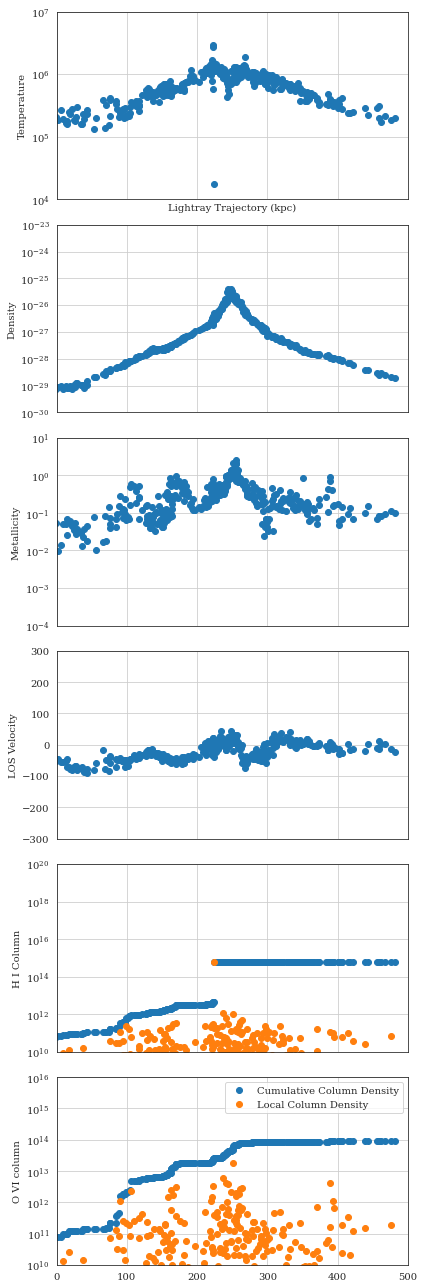

In [41]:
plot_sightline_data('P0', 69)
#plot_sightline_data('P0_agncr', 36)

In [106]:
def _los_vel(field, data):
    if data.has_field_parameter("bulk_velocity"):
        bv = data.get_field_parameter("bulk_velocity").in_units("km/s")
        print("heh", bv)
        sys.stdout.flush()
    else:
        print('wah')
        bv = data.ds.arr(np.zeros(3), "cm/s")
    vx = np.array((data[('gas', 'velocity_x')] - bv[0]).in_units('km/s'))
    vy = np.array((data[('gas', 'velocity_y')] - bv[1]).in_units('km/s'))
    vz = np.array((data[('gas', 'velocity_z')] - bv[2]).in_units('km/s'))
    
   # vel = np.column_stack((vx, vy, vz))
    if data.has_field_parameter("normal"):
        r_hat = data.get_field_parameter("normal")
        print("normal vector = ", r_hat)
    else:
        ('warning: no ray_norm')
        r_hat = [0, 0, 1]
        
    r_hat_mag = np.linalg.norm(r_hat)
    r_hat = np.divide(r_hat, r_hat_mag)
    
   # v_dot_rhat = np.dot(vel, r_hat) 
    v_dot_rhat = vx*r_hat[0] + vy*r_hat[1] + vz*r_hat[2]
    print(v_dot_rhat.shape)
    return YTArray(v_dot_rhat, 'km/s')

In [16]:
from yt.fields.api import ValidateParameter

ds = yt.load('/Users/irynabutsky/simulations/patient0/pioneer.003195')
ad = ds.all_data()
ad.set_field_parameter('bulk_velocity', YTArray([0, 0, 100], 'km/s'))
ad.set_field_parameter('normal', [0, 0, 1])
ds.add_field(('all', 'ray_los_velocity2'), function = _los_vel, particle_type = True,
             force_override = True, units = 'km/s', validators=[ValidateParameter(['normal', 'bulk_velocity'])])

code_unit_conversion = ds.domain_right_edge.d / ds.domain_right_edge.in_units('kpc').d

width = np.array([200., 10., 10.]) # kpc
width *= code_unit_conversion
print(width)
#image_test_bv_z = yt.off_axis_projection(ds, ray_center, ray_direction, width, 
#                                   [600, 30], ('all', 'ray_los_velocity2'),
#                               weight = ('gas', 'density'))
image_bv_z = yt.off_axis_projection(ds, ray_center, ray_direction, width, 
                                  [1200, 60], ('gas', 'velocity_z'),
                               weight = ('gas', 'density'))


yt : [INFO     ] 2021-01-29 15:21:09,279 Parameters: current_time              = 3.3988696927205075e+17 s
yt : [INFO     ] 2021-01-29 15:21:09,280 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-01-29 15:21:09,281 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2021-01-29 15:21:09,282 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2021-01-29 15:21:09,282 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2021-01-29 15:21:09,283 Parameters: current_redshift          = 0.2497948824964893
yt : [INFO     ] 2021-01-29 15:21:09,284 Parameters: omega_lambda              = 0.6914
yt : [INFO     ] 2021-01-29 15:21:09,284 Parameters: omega_matter              = 0.3086
yt : [INFO     ] 2021-01-29 15:21:09,285 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-01-29 15:21:09,285 Parameters: hubble_constant           = 0.677583430663222
yt : [INFO     ] 2021-01-29 15:21:09,289 Allocating for 1.447e+06 p

TypeError: add_field() missing 1 required positional argument: 'sampling_type'

In [89]:
r_hat = np.array([1, 0, 1])
vx = np.array([1, 2, 3, 4])
vy = np.array([5, 6, 7, 8])
vz = np.array([9, 10, 11, 12])

vel = np.column_stack((vx, vy, vz))

v_dot_rhat = vx*r_hat[0] + vy*r_hat[1] + vz*r_hat[2]
vx *= r_hat[0]
vy *= r_hat[1]
vz *= r_hat[2]

print(len(vx), len(vy), len(vz))
#vel = np.column_stack((vx, vy, vz)
                      
v_dot_rhat = np.dot(vel, r_hat)
print((vel.shape))
print(v_dot_rhat)



4 4 4
(4, 3)
[10 12 14 16]


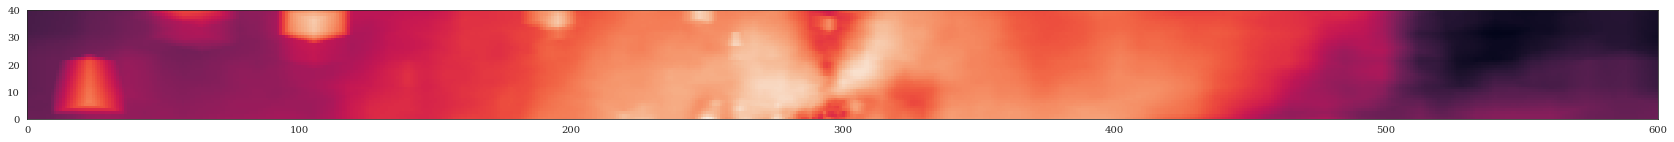

In [58]:
fig, ax = plt.subplots(1, 1, figsize = (30, 2))
ax.pcolormesh(image2.T, norm = LogNorm())
ax.set_aspect('equal')

yt : [INFO     ] 2020-04-28 15:44:56,005 xlim = -0.006249 0.006249
yt : [INFO     ] 2020-04-28 15:44:56,006 ylim = -0.000250 0.000250
yt : [INFO     ] 2020-04-28 15:44:56,007 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



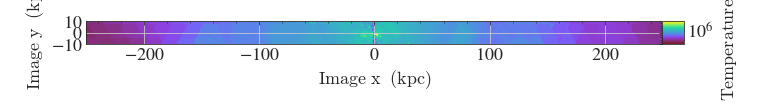

In [21]:
s = yt.OffAxisSlicePlot(ds, [1, 1, 1], ('gas', 'temperature'), center = gcenter, width = ((300, 'kpc'), (20, 'kpc')))
s.show()

In [104]:
import palettable
def get_cmap(field):
    if field =='density':
        cmap = palettable.cmocean.sequential.Tempo_20.mpl_colormap
    elif field == 'pressure':
        cmap = 'magma'
    elif field == 'temperature':
        cmap = palettable.scientific.sequential.LaJolla_20_r.mpl_colormap
    elif field == 'cr_eta':
        cmap = palettable.scientific.sequential.Tokyo_20.mpl_colormap
    elif field == 'cr_pressure':
        cmap = palettable.scientific.sequential.Turku_20.mpl_colormap
    elif field == 'velocity_magnitude' or field == 'velocity_los':
        cmap = palettable.scientific.diverging.Vik_20.mpl_colormap
    elif field == 'magnetic_field_strength':
        cmap = palettable.scientific.sequential.LaPaz_20.mpl_colormap
    elif field == 'H_p0_number_density':
        cmap = 'purple_mm'
    elif field == 'O_p5_number_density':
        cmap = 'dusk'
    elif field == 'metallicity':
        cmap = 'gist_earth'
    else:
        cmap = 'viridis'
        print(field, ' not mapped')
    return cmap

def los_vel(vx, vy, vz, bv = [0, 0, 0], normal = [0, 0, 1]):
    vx = np.array(vx - bv[0])
    vy = np.array(vy - bv[1])
    vz = np.array(vz - bv[2])
    #vel = np.column_stack((vx, vy, vz))

    normal_mag = np.linalg.norm(normal)
    normal = np.divide(normal, normal_mag)
    #normal = np.column_stack(normal)
    
    #print(vel.shape, normal.shape)
    #v_dot_norm = np.dot(vel, normal) 
    v_dot_norm = vx*normal[0] + vy*normal[1] + vz*normal[2]
   # print(v_dot_rhat.shape)
    return v_dot_norm

['H_p0_number_density', 'O_p5_number_density', 'Si_p2_number_density', 'density', 'metallicity', 'temperature', 'velocity_magnitude', 'velocity_x', 'velocity_y', 'velocity_z']
Si_p2_number_density  not mapped


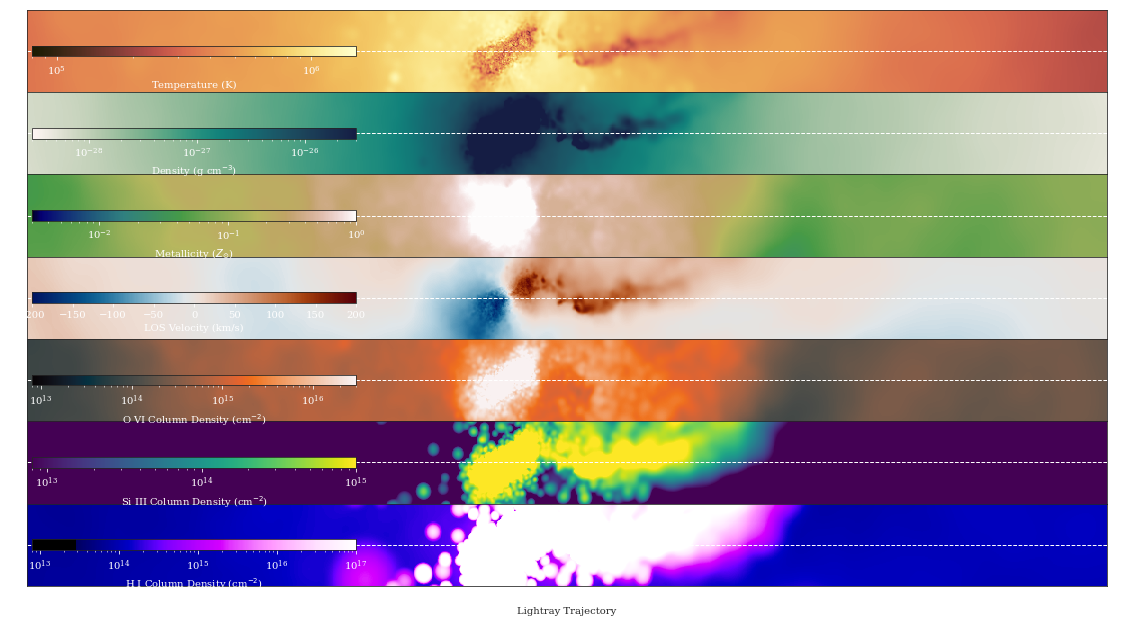

In [109]:
#import matplotlib as mpl
#plt.rcParams.update({"text.usetex":False})
ray_id = 5
model = 'P0'
f = h5.File('../../data/ray_files/ray_image_data_%s_3195_%i.h5'%(model, ray_id), 'r')
#f = h5.File('~/Dropbox/SyntheticSpecCGM/ENZO/data/ray_files/ray_P0_3195_3.h5', 'r')

print(list(f.keys()))
params = {"xtick.color" : "white", 
          "ytick.color" : "white"} 
plt.rcParams.update(params)
field_list = ['temperature', 'density', 'metallicity', 'velocity_los', 
              'O_p5_number_density', 'Si_p2_number_density', 'H_p0_number_density']
zlim_list  = [(8e4, 1.5e6), (3e-29, 3e-26), (3e-3, 1), (-200, 200), (8e12, 3e16),
              (8e12, 1e15), (8e12, 1e17)]
ylabel_list = ['Temperature (K)', 'Density (g cm$^{-3}$)', 'Metallicity ($Z_{\odot}$)', 
                    'LOS Velocity (km/s)', 'O VI Column Density (cm$^{-2}$)',
                   'Si III Column Density (cm$^{-2}$)', 'H I Column Density (cm$^{-2}$)']

#ylabel_list = field_list

fig, ax = plt.subplots(nrows = 7, ncols =1, figsize = (15, 8))
for i, field in enumerate(field_list):
    if field == 'velocity_los':
        vx = np.array(f['velocity_x']) / 1e5
        vy = np.array(f['velocity_y']) / 1e5
        vz = np.array(f['velocity_z']) / 1e5
        ray_direction = end_pos[ray_id] - start_pos[ray_id]
        image = los_vel(vx, vy, vz, bv = [bvx[0], bvy[0], bvz[0]], normal = ray_direction)
        norm = None
    else:
        image = np.array(f[field])
        norm = LogNorm()
    if field == 'metallicity':
        image *= 77.22007722007721  # converting from code units to zsun

    im = ax[i].pcolormesh(image.T, norm = norm, cmap = get_cmap(field),
                          vmin = zlim_list[i][0], vmax = zlim_list[i][1])
    ax[i].axhline(40, linewidth = 1, color = 'white', linestyle = 'dashed')
    cbax = inset_axes(ax[i], width = "30%", height = "13%", loc = 6)
    cbar = fig.colorbar(im, cax=cbax, orientation = 'horizontal')
    cbar.set_label(ylabel_list[i], color = 'white')
    
    
    
    
#    cbar = plt.colorbar(im, ax = ax[i], label = ylabel_list[i], pad = 0)
    
#    if i < len(field_list) -1:
#        ax[i].set_xticks([])
#    ax[i].set_yticks([])
    

ax[-1].set_xlabel('Lightray Trajectory')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
#plt.savefig('../../plots/ray_P0_3195_%i.png'%ray_id, dpi = 300)
plt.savefig('test.png', dpi= 300)

In [92]:
# testing randomness of sightlines
ray_id, impact, xs, ys, zs, xe, ye, ze = np.loadtxt('../analysis/random_sightlines.dat', skiprows=1, unpack = True)

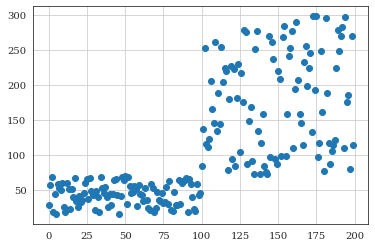

In [93]:
plt.scatter(ray_id, impact)

61

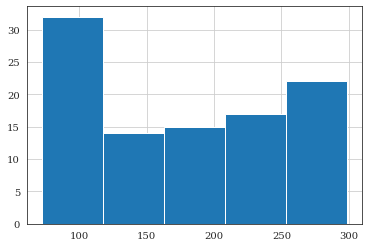

In [98]:
plt.hist(impact[impact>71], bins = 5)
len(impact[impact<50])

(-600.0, 600.0)

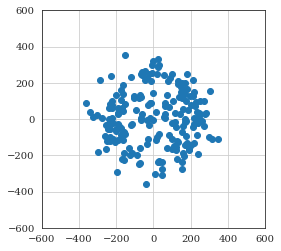

In [102]:
fig, ax = plt.subplots(figsize = (4, 4))
ax.scatter(ye, ze)
ax.set_xlim(-600, 600)
ax.set_ylim(-600, 600)
#ax.set_aspect_ratio('equal')

In [101]:
import csv
from astropy import constants as const
c = const.c.to('km/s').value

csvfile = '/Users/irynabutsky/Downloads/merged_solutions.csv'
data = csv.reader(open(csvfile, 'rt'))

ion_list, logN_list, logNerr_list, b_list, berr_list, zcen_list, \
    zcen_sd_list, ray_id_list, model_list = [], [],[],[],[],[],[],[],[]

counter = 0
for row in data:
    if counter > 0:
        ion_list.append(row[0])
        logN_list.append(float(row[1]))
        logNerr_list.append(float(row[2]))
        b_list.append(float(row[3]))
        berr_list.append(float(row[4]))
        zcen_list.append(float(row[5]))
        zcen_sd_list.append(float(row[6]))
        ray_id_list.append(int(row[7][-4:]))
        model_list.append(row[7][:-4])
    counter += 1
                      
ion_list = np.array(ion_list)
logN_list = np.array(logN_list)
logNerr_list = np.array(logNerr_list)
b_list = np.array(b_list)
berr_list = np.array(berr_list)
zcen_list = np.array(zcen_list)
zcen_sd_list = np.array(zcen_sd_list)
ray_id_list = np.array(ray_id_list)
model_list = np.array(model_list)

zsys = 0.25
vel_list = c * ((1 + zcen_list) / (1 + zsys) - 1)

# make O VI labels
ovi_label_list = np.array(len(vel_list)*[None])
for i in range(max(ray_id_list)):
    for model in ['P0', 'P0agncr']:
        ovi_mask = (ray_id_list == i) & (model_list == model) & (ion_list == 'OVI')
        siIII_mask = (ray_id_list == i) & (model_list == model) & (ion_list == 'SiIII')
        #print(i, model, ion_list[ovi_mask], ion_list[siIII_mask])
        if len(ion_list[ovi_mask]) == 0:
            continue
        if len(ion_list[siIII_mask]) == 0:
            ovi_label_list[ovi_mask] = 'nolow'
        else:
            o_vel_list = vel_list[ovi_mask]
            si_vel_list = vel_list[siIII_mask]
            for j, o_vel in enumerate(o_vel_list):
                dvel_list = o_vel - si_vel_list
                ovi_label_mask = ovi_mask & (vel_list == o_vel)
               # print(dvel_list, min(np.abs(dvel_list)))
                if min(np.abs(dvel_list)) > 35:
                  #  print(j, 'nolow', ovi_label_list[ovi_mask])
                    ovi_label_list[ovi_label_mask] = 'nolow'
                   # print('theoretical update',  ovi_label_list[ovi_mask])
                elif b_list[ovi_label_mask] > 40:
                    ovi_label_list[ovi_label_mask] = 'broad'
                else:
                    ovi_label_list[ovi_label_mask] = 'narrow'
            
idx, impacts = np.loadtxt('../../data/random_sightlines.dat', unpack = True, skiprows = 1, usecols = (0, 1))            
impact_list = np.array([])
for i, ray_id in enumerate(ray_id_list):
    mask = idx == ray_id
    r = impacts[mask][0]
    impact_list = np.append(impact_list, r)


In [102]:
for ray_id, impact in zip(ray_id_list, impact_list):
    print(ray_id, impact)

0 28.45
0 28.45
1 57.61
3 18.74
5 15.66
5 15.66
5 15.66
5 15.66
5 15.66
5 15.66
5 15.66
5 15.66
5 15.66
5 15.66
5 15.66
5 15.66
5 15.66
5 15.66
6 58.07
6 58.07
7 53.2
7 53.2
7 53.2
7 53.2
7 53.2
7 53.2
7 53.2
7 53.2
8 50.04
9 59.25
9 59.25
10 25.61
10 25.61
11 18.74
11 18.74
11 18.74
11 18.74
11 18.74
11 18.74
11 18.74
11 18.74
11 18.74
11 18.74
12 59.64
12 59.64
13 50.78
14 22.95
14 22.95
15 51.63
16 40.04
17 67.64
18 33.51
19 25.0
19 25.0
19 25.0
19 25.0
19 25.0
19 25.0
19 25.0
19 25.0
20 40.84
20 40.84
20 40.84
21 32.0
21 32.0
21 32.0
21 32.0
22 35.12
22 35.12
23 45.62
24 59.27
24 59.27
26 37.05
29 42.46
29 42.46
29 42.46
30 21.68
30 21.68
30 21.68
30 21.68
30 21.68
30 21.68
31 48.54
32 39.82
33 18.7
33 18.7
33 18.7
33 18.7
33 18.7
33 18.7
33 18.7
33 18.7
33 18.7
33 18.7
33 18.7
33 18.7
34 67.83
35 52.58
35 52.58
35 52.58
35 52.58
35 52.58
35 52.58
36 46.09
38 40.14
41 28.16
41 28.16
41 28.16
41 28.16
43 64.6
44 65.91
45 43.34
46 15.65
48 69.04
48 69.04
48 69.04
48 69.04
49 64.04
51

91 18.31
91 18.31
91 18.31
91 18.31
91 18.31
91 18.31
92 65.25
92 65.25
92 65.25
93 58.79
93 58.79
93 58.79
93 58.79
93 58.79
93 58.79
93 58.79
94 39.4
94 39.4
94 39.4
94 39.4
94 39.4
94 39.4
94 39.4
94 39.4
94 39.4
95 22.15
95 22.15
95 22.15
95 22.15
95 22.15
95 22.15
95 22.15
95 22.15
95 22.15
95 22.15
95 22.15
95 22.15
95 22.15
95 22.15
96 20.14
96 20.14
96 20.14
96 20.14
96 20.14
96 20.14
96 20.14
96 20.14
96 20.14
96 20.14
96 20.14
96 20.14
96 20.14
96 20.14
96 20.14
96 20.14
96 20.14
97 58.43
97 58.43
98 43.39
98 43.39
98 43.39
98 43.39
98 43.39
99 45.92
99 45.92
99 45.92
99 45.92
99 45.92
101 137.02
102 253.5
104 111.24
107 165.6
111 189.03
111 189.03
112 143.95
112 143.95
112 143.95
122 84.21
123 182.13
125 103.93
126 217.5
126 217.5
128 278.53
130 87.22
130 87.22
130 87.22
132 168.61
132 168.61
133 90.71
134 72.95
135 251.48
136 277.91
137 134.66
138 72.52
138 72.52
138 72.52
138 72.52
138 72.52
138 72.52
139 117.63
139 117.63
142 75.26
142 75.26
145 97.42
145 97.42
145 97.42


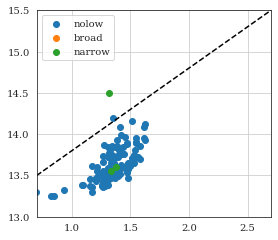

In [86]:
model = 'P0'
fig, ax = plt.subplots(figsize = (4.2, 3.8))
ax.plot([0.7, 2.7], [13.5, 15.5], color = 'black', linestyle = 'dashed')

label_list = ['nolow', 'broad', 'narrow']
color_list = ['']
for label in label_list:
    mask = (ion_list == 'OVI') & (model_list == model) & (ovi_label_list == label)
    ax.scatter(np.log10(b_list[mask]), logN_list[mask], label = label)
ax.set_xlim(0.7, 2.7)
ax.set_ylim(13.0, 15.5)   
ax.legend()

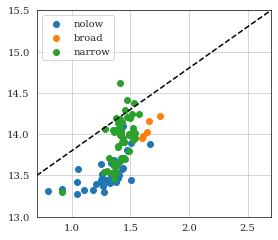

In [87]:
model = 'P0agncr'
fig, ax = plt.subplots(figsize = (4.2, 3.8))
ax.plot([0.7, 2.7], [13.5, 15.5], color = 'black', linestyle = 'dashed')

label_list = ['nolow', 'broad', 'narrow']
color_list = ['']
for label in label_list:
    mask = (ion_list == 'OVI') & (model_list == model) & (ovi_label_list == label)
    ax.scatter(np.log10(b_list[mask]), logN_list[mask], label = label)
ax.set_xlim(0.7, 2.7)
ax.set_ylim(13.0, 15.5)   
ax.legend()

(13.0, 15.5)

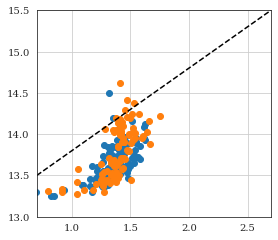

In [32]:
po_mask = (ion == 'OVI') & (model == 'P0')
pocr_mask = (ion == 'OVI') & (model == 'P0agncr')

fig, ax = plt.subplots(figsize = (4.2, 3.8))
ax.plot([0.7, 2.7], [13.5, 15.5], color = 'black', linestyle = 'dashed')

ax.scatter(np.log10(b[po_mask]), logN[po_mask])
ax.scatter(np.log10(b[pocr_mask]), logN[pocr_mask])
ax.set_xlim(0.7, 2.7)
ax.set_ylim(13.0, 15.5)


(-200.0, 200.0)

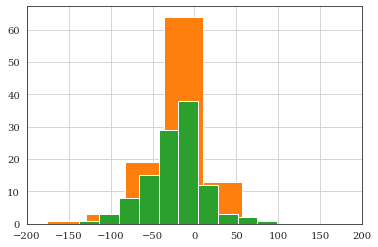

In [31]:
plt.hist(vels[po_mask])
plt.hist(vels[pocr_mask])
plt.hist(vels[po_mask])

plt.xlim(-200, 200)

(array([ 9.,  6.,  7.,  3.,  6.,  3.,  8., 17., 11.,  6.]),
 array([12.16246124, 12.56092601, 12.95939078, 13.35785556, 13.75632033,
        14.1547851 , 14.55324988, 14.95171465, 15.35017942, 15.7486442 ,
        16.14710897]),
 <a list of 10 Patch objects>)

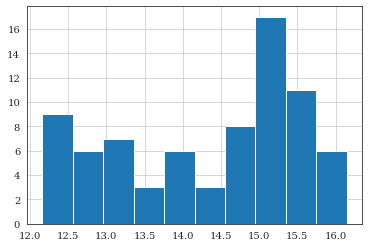

In [19]:
mask = (ion == 'SiIII') & (model == 'P0agncr')
plt.hist(logN[mask])

In [26]:
0.25 - 0.2497533244

0.0002466755999999959